In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Load the cleaned, model-ready dataset
df = pd.read_csv("../data/heart_disease_model_ready.csv")

# Separate features and target
X = df.drop(columns=['num'])   # or 'target' depending on your dataset
y = df['num']

print("Shape:", X.shape)
X.head()


Shape: (303, 13)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.948726,0.686202,-2.251775,0.757525,-0.264900,2.394438,1.016684,0.017197,-0.696631,1.087338,2.274579,-0.711131,0.660004
1,1.392002,0.686202,0.877985,1.611220,0.760415,-0.417635,1.016684,-1.821905,1.435481,0.397182,0.649113,2.504881,-0.890238
2,1.392002,0.686202,0.877985,-0.665300,-0.342283,-0.417635,1.016684,-0.902354,1.435481,1.346147,0.649113,1.432877,1.176752
3,-1.932564,0.686202,-0.165268,-0.096170,0.063974,-0.417635,-0.996749,1.637359,-0.696631,2.122573,2.274579,-0.711131,-0.890238
4,-1.489288,-1.457296,-1.208521,-0.096170,-0.825922,-0.417635,1.016684,0.980537,-0.696631,0.310912,-0.976352,-0.711131,-0.890238


In [2]:
# Train RandomForest for feature importance
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display top 10
importances.head(10)


thalach     0.140234
oldpeak     0.119568
chol        0.112841
age         0.112819
trestbps    0.097857
ca          0.097238
thal        0.080424
cp          0.077125
exang       0.045362
slope       0.041279
dtype: float64

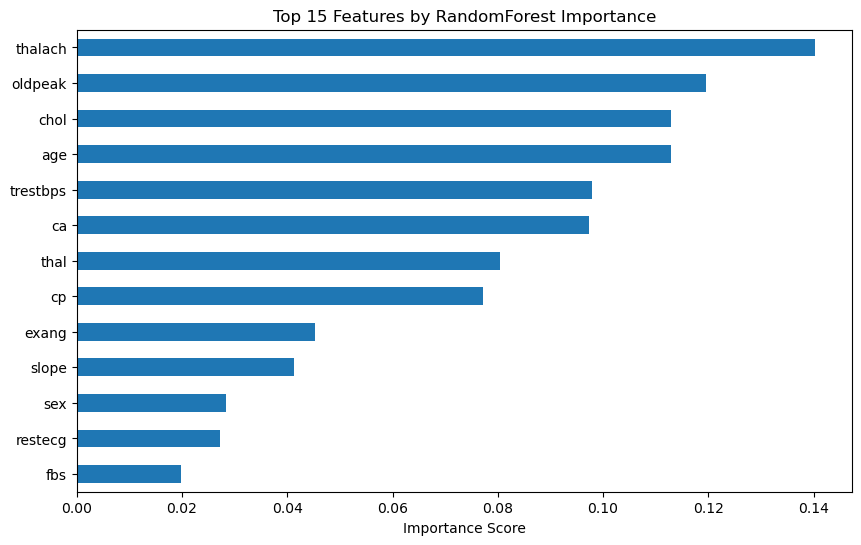

In [3]:
plt.figure(figsize=(10,6))
importances.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 15 Features by RandomForest Importance")
plt.xlabel("Importance Score")
plt.show()


In [4]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Logistic Regression (for RFE)
lr = LogisticRegression(max_iter=2000, solver="liblinear")

# Recursive Feature Elimination: keep top 8 predictors (you can change n_features_to_select)
rfe = RFE(estimator=lr, n_features_to_select=8)
rfe.fit(X, y)

# Get selected features
selected_features = X.columns[rfe.support_]
print("Selected features by RFE:", selected_features.tolist())


Selected features by RFE: ['sex', 'cp', 'restecg', 'thalach', 'exang', 'oldpeak', 'ca', 'thal']


In [5]:
# Rank each feature (1 = most important, higher = less important)
rfe_ranking = pd.DataFrame({
    "Feature": X.columns,
    "Rank": rfe.ranking_
}).sort_values("Rank")

rfe_ranking


,Feature,Rank
1,sex,1
2,cp,1
6,restecg,1
7,thalach,1
8,exang,1
9,oldpeak,1
11,ca,1
12,thal,1
5,fbs,2
0,age,3


In [7]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

# Chi2 requires non-negative values → scale features to [0,1]
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

# Select top 8 features (you can change k)
chi2_selector = SelectKBest(score_func=chi2, k=8)
chi2_selector.fit(X_minmax, y)

chi2_scores = pd.DataFrame({
    "Feature": X.columns,
    "Chi2 Score": chi2_selector.scores_
}).sort_values("Chi2 Score", ascending=False)

chi2_scores.head(10)


,Feature,Chi2 Score
12,thal,48.176108
8,exang,41.534482
11,ca,36.622292
9,oldpeak,16.451213
10,slope,14.046618
2,cp,8.234094
1,sex,7.499223
6,restecg,7.028775
5,fbs,6.658223
7,thalach,3.133976


In [9]:
# --- Top features from each method ---
top_rf = importances.head(10).index.tolist()       # top 10 from RandomForest
top_rfe = selected_features.tolist()               # selected by RFE
top_chi2 = chi2_scores.head(10)['Feature'].tolist() # top 10 from Chi²

print("Top RF features:", top_rf)
print("Top RFE features:", top_rfe)
print("Top Chi2 features:", top_chi2)

# --- Intersection (common features across methods) ---
common_features = list(set(top_rf) & set(top_rfe) & set(top_chi2))
print("Common features across all methods:", common_features)

# --- Union (all unique features across methods) ---
union_features = list(set(top_rf) | set(top_rfe) | set(top_chi2))
print("Union of selected features:", union_features)


Top RF features: ['thalach', 'oldpeak', 'chol', 'age', 'trestbps', 'ca', 'thal', 'cp', 'exang', 'slope']
Top RFE features: ['sex', 'cp', 'restecg', 'thalach', 'exang', 'oldpeak', 'ca', 'thal']
Top Chi2 features: ['thal', 'exang', 'ca', 'oldpeak', 'slope', 'cp', 'sex', 'restecg', 'fbs', 'thalach']
Common features across all methods: ['exang', 'thalach', 'ca', 'cp', 'thal', 'oldpeak']
Union of selected features: ['thalach', 'cp', 'thal', 'trestbps', 'chol', 'exang', 'age', 'restecg', 'fbs', 'ca', 'slope', 'sex', 'oldpeak']


In [10]:
# Choose final feature set: intersection (strict) or union (lenient)
# Here we use union for broader coverage
final_features = union_features  

# Reduced dataset
X_selected = X[final_features]

print("Final feature set size:", len(final_features))
print("Selected features:", final_features)

# Save reduced dataset
df_selected = pd.concat([X_selected, y], axis=1)
df_selected.to_csv("../data/heart_disease_selected_features.csv", index=False)
print("Saved:", "../data/heart_disease_selected_features.csv")


Final feature set size: 13
Selected features: ['thalach', 'cp', 'thal', 'trestbps', 'chol', 'exang', 'age', 'restecg', 'fbs', 'ca', 'slope', 'sex', 'oldpeak']
Saved: ../data/heart_disease_selected_features.csv
